In [ ]:
!pip install -U segmentation-models

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from mpl_toolkits.axes_grid import ImageGrid
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from random import sample
import os
import glob
import random
import nibabel as nib
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from tensorflow.keras.utils import normalize
import segmentation_models as sm

sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [ ]:
uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!cd /root/.kaggle/ && ls -la

Saving kaggle.json to kaggle.json
total 16
drwxr-xr-x 2 root root 4096 Oct  3 04:45 .
drwx------ 1 root root 4096 Oct  2 20:20 ..
-rw------- 1 root root   65 Oct  3 04:45 kaggle.json


In [ ]:
!kaggle datasets download -d andrewmvd/covid19-ct-scans
!unzip /content/covid19-ct-scans

covid19-ct-scans.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/covid19-ct-scans.zip
replace ct_scans/coronacases_org_001.nii? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Reading Nil files 

In [ ]:
def readingNii(filepath):
  img = nib.load(filepath)
  array   = img.get_fdata()
  array   = np.array(array)
  return(array)

In [ ]:
sampleCTScan = readingNii('/content/ct_scans/coronacases_org_001.nii')
sampleLung = readingNii('/content/lung_mask/coronacases_001.nii')
sampleInfection = readingNii('/content/infection_mask/coronacases_001.nii')
sampleAll = readingNii('/content/lung_and_infection_mask/coronacases_001.nii')

[]

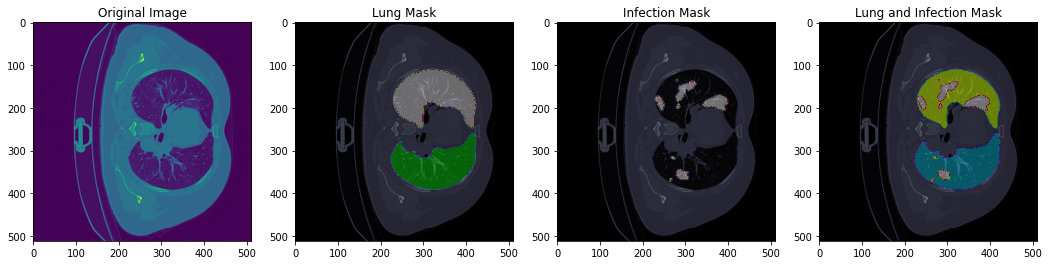

In [ ]:
fig = plt.figure(figsize = (18,15))
plt.subplot(1,4,1)
num = 189
plt.imshow(sampleCTScan[:, :, num])
plt.title('Original Image')

plt.subplot(1,4,2)
plt.imshow(sampleCTScan[..., num], cmap = 'bone')
plt.imshow(sampleLung[..., num],alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung Mask')

plt.subplot(1,4,3)
plt.imshow(sampleCTScan[..., num], cmap = 'bone')
plt.imshow(sampleInfection[..., num], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Infection Mask')

plt.subplot(1,4,4)
plt.imshow(sampleCTScan[..., num], cmap = 'bone')
plt.imshow(sampleAll[..., num], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung and Infection Mask')
plt.plot()

In [ ]:
print(sampleCTScan.shape)

(512, 512, 301)


In [ ]:
data = pd.read_csv('metadata.csv')
data_size = data.shape[0]

In [ ]:
!pwd

/content


In [ ]:
lungs = []
infections = []
img_size = 256

for i in range(data_size):
    ct = readingNii('/content/ct_scans/' + data['ct_scan'][i].strip().split('/')[-1])
    infect = readingNii('/content/infection_mask/' + data['infection_mask'][i].strip().split('/')[-1])
    print(ct.shape)

    for ii in range(ct.shape[0]):
        lung_img = cv2.resize(ct[ii], dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')
        infec_img = cv2.resize(infect[ii],dsize=(img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')
        # lungs.append(lung_img[..., np.newaxis])
        # infections.append(infec_img[..., np.newaxis])

        lungs.append(lung_img)
        infections.append(infec_img)


    print("len of lungs: " + str(len(lungs)))

lung = np.array(lungs)
infections = np.array(infections)

(512, 512, 301)
len of lungs: 512
(512, 512, 200)
len of lungs: 1024
(512, 512, 200)
len of lungs: 1536
(512, 512, 270)
len of lungs: 2048
(512, 512, 290)
len of lungs: 2560
(512, 512, 213)
len of lungs: 3072
(512, 512, 249)
len of lungs: 3584
(512, 512, 301)
len of lungs: 4096
(512, 512, 256)
len of lungs: 4608
(512, 512, 301)
len of lungs: 5120
(630, 630, 39)
len of lungs: 5750
(630, 630, 418)
len of lungs: 6380
(630, 401, 110)
len of lungs: 7010
(630, 630, 66)
len of lungs: 7640
(630, 630, 42)
len of lungs: 8270
(630, 630, 42)
len of lungs: 8900
(630, 630, 45)
len of lungs: 9530
(630, 630, 93)
len of lungs: 10160
(630, 630, 39)
len of lungs: 10790
(630, 630, 45)
len of lungs: 11420


In [ ]:
print(lung.shape)

(11420, 256, 256)


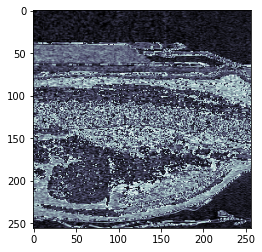

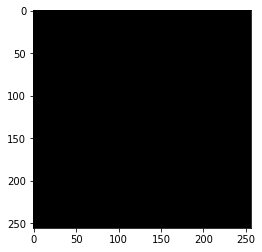

In [ ]:
num = 2793
plt.imshow(lung[num, ...], cmap='bone')
plt.show()
plt.imshow(infections[num,...], cmap = 'nipy_spectral')
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(lungs, infections, test_size = 0.20)

In [ ]:
x_train, x_test, y_train, y_test = np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]
y_train = y_train[..., np.newaxis]
y_test = y_test[..., np.newaxis]

In [ ]:
y_test.shape, y_test.shape, x_train.shape, y_train.shape

((2284, 256, 256, 1),
 (2284, 256, 256, 1),
 (9136, 256, 256, 1),
 (9136, 256, 256, 1))

In [ ]:
np.ptp(x_train)

255

In [ ]:
# Data augmentation argument

img_data_gen_args = dict(rescale = 1./255., dtype = np.float32)

# This takes a preprocessing_function lambda as input that changes all labels into binary value (ie. either 0 or 255)
mask_data_gen_args = dict(
                     rescale = 1./255.,
                     preprocessing_function = lambda x: np.where(x>0, 255., 0).astype(x.dtype),
                     dtype = np.float32) #Binarize the output again. 


normalize_data_gen_args = dict(rescale = 1./255., dtype = np.float32)

normalize_mask_gen_args = dict(rescale = 1./255., dtype = np.float32)

In [ ]:
# seed = 24

# image_data_generator = ImageDataGenerator(**img_data_gen_args)
# image_data_generator.fit(x_train, seed=seed)
# image_generator = image_data_generator.flow(x_train, seed=seed, batch_size = 32)
# image_data_generator = ImageDataGenerator(**mask_data_gen_args)
# image_data_generator.fit(x_test, seed = seed)
# valid_data_generator = image_data_generator.flow(x_test, seed = seed, batch_size = 32)

# mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
# mask_data_generator.fit(y_train, seed=seed)
# mask_generator = mask_data_generator.flow(y_train, seed=seed, batch_size = 32)
# mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
# mask_data_generator.fit(y_test, seed = seed)
# valid_mask_generator = mask_data_generator.flow(y_test, seed = seed, batch_size = 32)

In [ ]:
# def my_image_mask_generator(image_generator, mask_generator):
#     train_generator = zip(image_generator, mask_generator)
#     for (img, mask) in train_generator:
#         yield (img, mask)

# my_generator = my_image_mask_generator(image_generator, mask_generator)
# validation_datagen = my_image_mask_generator(valid_data_generator, valid_mask_generator)

In [ ]:
checkpointer = ModelCheckpoint(filepath="./Models", 
                               save_best_only=True,
                               save_weights_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2,
                              verbose = 1
                             )

In [ ]:
print(type(checkpointer))

<class 'keras.callbacks.ModelCheckpoint'>


In [ ]:
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.5, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss(gamma = 2)
total_loss = dice_loss + (1 * focal_loss)
BACKBONE = 'resnet34'
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
adam = tf.keras.optimizers.Adam(learning_rate= 0.005)

In [ ]:
N = x_train.shape[-1]
x_train.shape

(9136, 256, 256, 1)

In [ ]:
model = sm.Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None, None, N), classes = 1)
model.compile(optimizer = adam,
              loss = 'binary_crossentropy',
              metrics = [iou_score])

In [ ]:
process_input = sm.get_preprocessing(BACKBONE)
x_train = process_input(x_train)
x_test = process_input(x_test)

In [ ]:
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [ ]:
np.ptp(x_train)

255.0

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 1 3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 1 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 3136        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [ ]:
history = model.fit(x_train, y_train, epochs = 100, batch_size = 32, validation_data = (x_test, y_test))

Epoch 1/100
286/286 [==============================] - 100s 269ms/step - loss: 0.0476 - iou_score: 0.1315 - val_loss: 0.0730 - val_iou_score: 0.1004
Epoch 2/100
286/286 [==============================] - 74s 258ms/step - loss: 0.0210 - iou_score: 0.2435 - val_loss: 0.0702 - val_iou_score: 0.0655
Epoch 3/100
286/286 [==============================] - 74s 258ms/step - loss: 0.0166 - iou_score: 0.3414 - val_loss: 0.0338 - val_iou_score: 0.1405
Epoch 4/100
286/286 [==============================] - 74s 257ms/step - loss: 0.0148 - iou_score: 0.3836 - val_loss: 0.0163 - val_iou_score: 0.3948
Epoch 5/100
286/286 [==============================] - 74s 257ms/step - loss: 0.0136 - iou_score: 0.4153 - val_loss: 0.0330 - val_iou_score: 0.2145
Epoch 6/100
286/286 [==============================] - 74s 257ms/step - loss: 0.0128 - iou_score: 0.4346 - val_loss: 0.0132 - val_iou_score: 0.4408
Epoch 7/100
286/286 [==============================] - 74s 257ms/step - loss: 0.0126 - iou_score: 0.4395 - val_

In [ ]:
model.save('seg_model.h5')


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
from google.colab import files
files.download('seg_model.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>